In [68]:
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm
from math import isclose
from scipy.optimize import fmin, minimize, root_scalar
import pickle
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from Ising_integrals import *
from routines import *
from known_formulas import *

## RS computation

In [58]:
p = 3
n_points_m = 1_000
n_points_T = 7
n_points_more_T = 3

T_kauz, T_dyn = get_Tk_Td(p)

Teqs = np.hstack(
    (
        np.linspace(T_kauz, T_dyn, n_points_T),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
#Teqs = Teqs[27:]
es = -1 / (2 * Teqs)

In [61]:
# file_path = f'./data/rs_p{p:d}.pkl'
# if os.path.exists(file_path):
#    print("Data is already saved.")
#
#    with open(file_path, 'rb') as f:
#        tmp = pickle.load(f)
#        data = tmp['data']
#        ms = tmp['ms']
#
#    print("Data is loaded.")
# else:
# print("Data is not saved.")

ms = np.linspace(0.0, 0.999, n_points_m)
data = observables((len(Teqs), n_points_m))

for jdx, e in enumerate(tqdm(es, desc="RS")):
    for idx, m in enumerate(ms):
        h, q = fixed_points_h_q(m, e, p)
        beta = beta_q_e(q, m, e, p, h)

        data["q"][jdx, idx] = q
        data["h"][jdx, idx] = h
        data["T"][jdx, idx] = 1 / beta
        data["delta_f"][jdx, idx] = deltaf_FP(m, q, h, p, e)
        data["s"][jdx, idx] = s_FP(m, q, h, p, e)
        data["dAT"][jdx, idx] = dAT_condition(q, m, h, beta, -e, p)
        data["m_check"][jdx, idx] = compute_m_FP(m, q, h, p, e)
        data["e_check"][jdx, idx] = e_q_beta(q, m, beta, p)


# with open(f'./data/rs_p{p:d}.pkl', 'wb') as f:
#    pickle.dump({'data': data, 'ms': ms}, f)
#
# print("Data is saved.")

RS:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/ghio/Desktop/fixed-energy-slice/Ising_integrals.py:199: RuntimeWarning: overflow encountered in cosh
  return compute_m_FP(m, q, h, p, e) - m


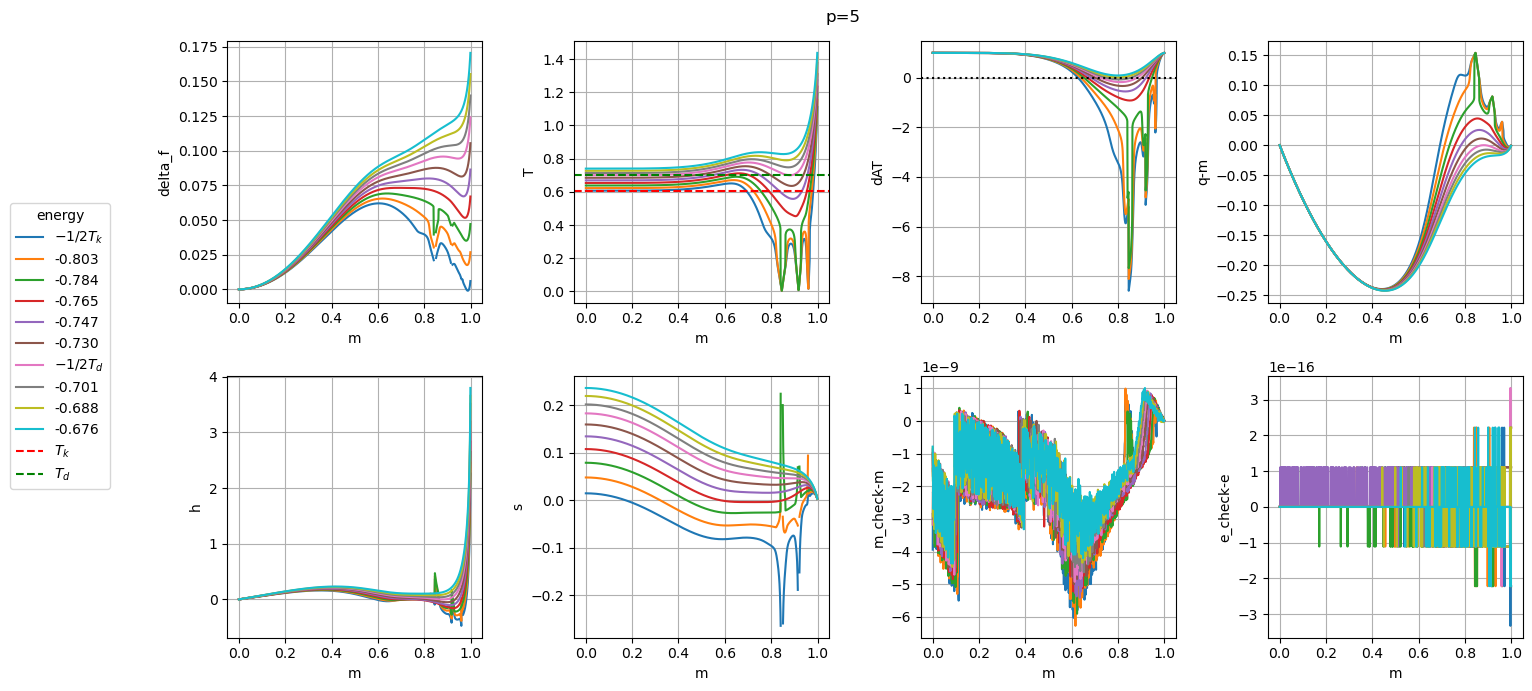

In [67]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle(f'p={p}')

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    for idx, (key, item) in enumerate(data.items()):
        if key == 'q':
            axs[idx // 4 , idx % 4].plot(ms, item[jdx,:]-ms, '-', label=legend_name)
            axs[idx // 4 , idx % 4].set_ylabel("q-m")
        elif key == 'm_check':
            axs[idx // 4 , idx % 4].plot(ms, item[jdx,:]-ms, '-', label=legend_name)
            axs[idx // 4 , idx % 4].set_ylabel("m_check-m")
        elif key == 'e_check':
            axs[idx // 4 , idx % 4].plot(ms, item[jdx,:]-e, '-', label=legend_name)
            axs[idx // 4 , idx % 4].set_ylabel("e_check-e")
        else:
            axs[idx // 4 , idx % 4].plot(ms, item[jdx,:], '-', label=legend_name)
            axs[idx // 4 , idx % 4].set_ylabel(key)

        axs[idx // 4 , idx % 4].set_xlabel('m')
        axs[idx // 4 , idx % 4].grid(True)

position_T = list(data.keys()).index('T')
axs[position_T // 4 , position_T % 4].axhline(y=T_kauz, color='r', linestyle='--', label=r'$T_k$')
axs[position_T // 4 , position_T % 4].axhline(y=T_dyn, color='g', linestyle='--', label=r'$T_d$')

position_dAT = list(data.keys()).index('dAT')
axs[position_dAT // 4 , position_dAT % 4].axhline(y=0, color='k', linestyle=':', label=r'$\Delta A = 0$')

handles, labels = [], []
# for ax in axs.flat:
ax = axs[0,1]
for handle, label in zip(*ax.get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)

lgd = fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
#plt.savefig(f'./imgs/FPpspin_p{p}.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=460)

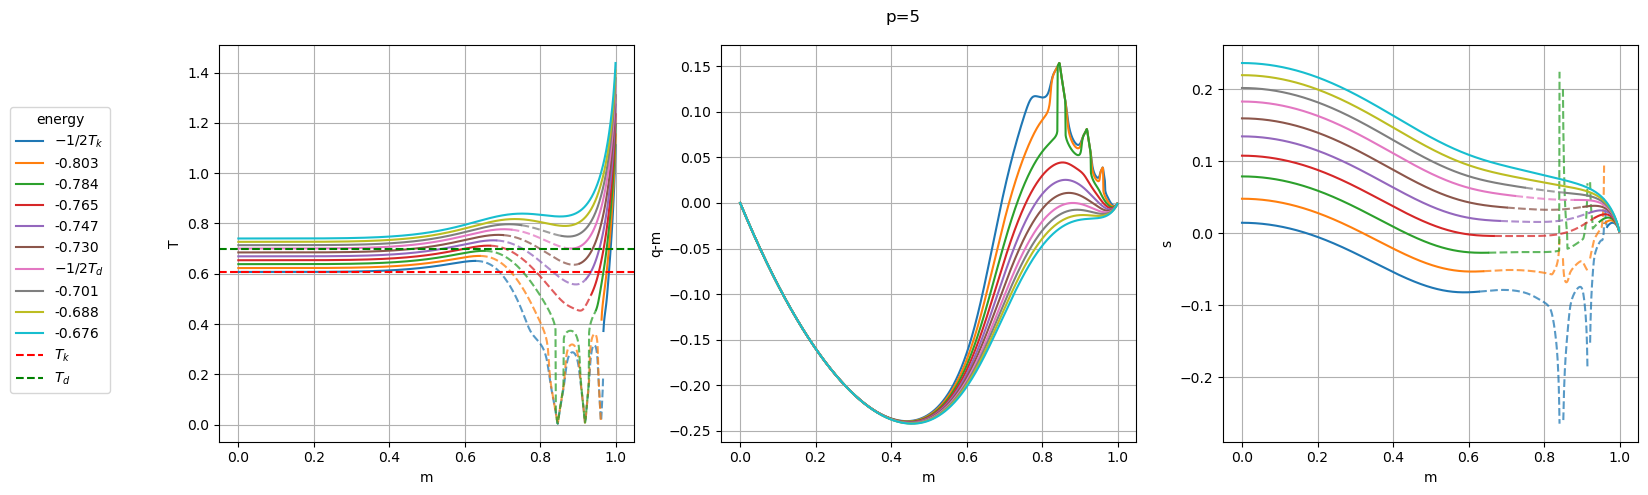

In [104]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"p={p}")

data_filtered = {
    key: value for key, value in data.items() if key in ["q", "T", "s"]
}

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    color = f"C{jdx:d}"
    stable_idxs = data["dAT"][jdx, :] > 0

    for idx, (key, item) in enumerate(data_filtered.items()):
        if key == 'q':
            axs[idx].plot(ms, item[jdx,:]-ms, '-', label=legend_name)
            axs[idx].set_ylabel("q-m")
        else:
            plot_dashed_instable(axs[idx], ms, item[jdx], stable_idxs, color, legend_name)
            axs[idx].set_ylabel(key)
        axs[idx].set_xlabel("m")
        axs[idx].grid(True)

position_T = list(data_filtered.keys()).index("T")
axs[position_T].axhline(y=T_kauz, color="r", linestyle="--", label=r"$T_k$")
axs[position_T].axhline(y=T_dyn, color="g", linestyle="--", label=r"$T_d$")

handles, labels = [], []
ax = axs[position_T]
for handle, label in zip(*ax.get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)

lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
# plt.savefig(
#     f"./imgs/FPpspin_p{p}_small.png",
#     bbox_extra_artists=(lgd,),
#     bbox_inches="tight",
#     dpi=360,
# )

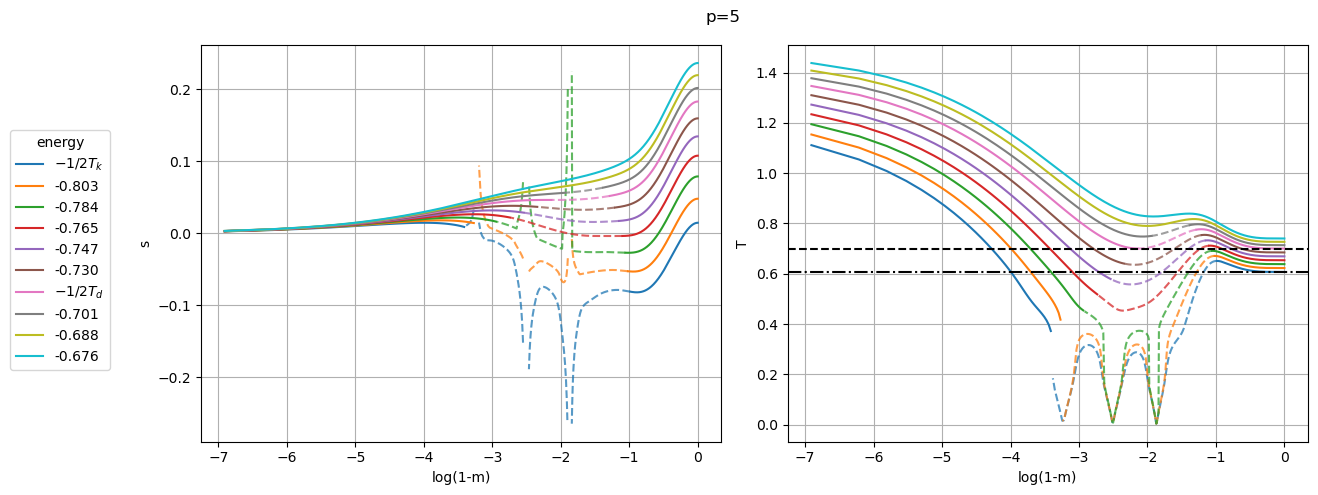

In [106]:
# plot s vs log(1-m) 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"p={p}")

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    color = f"C{jdx:d}"
    stable_idxs = data["dAT"][jdx, :] > 0

    plot_dashed_instable(ax[0], np.log(1-ms), data["s"][jdx], stable_idxs, color, legend_name)
    plot_dashed_instable(ax[1], np.log(1-ms), data["T"][jdx], stable_idxs, color, legend_name)
    #ax[0].plot(np.log(1-ms), data["s"][jdx], label=legend_name)
    #ax[1].plot(np.log(1-ms), data["T"][jdx], label=legend_name)

ax[0].set_ylabel("s")
ax[0].set_xlabel("log(1-m)")
ax[0].grid(True)

ax[1].set_ylabel("T")
ax[1].set_xlabel("log(1-m)")
ax[1].grid(True)
handles, labels = [], []
for handle, label in zip(*ax[1].get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)
position_T = list(data_filtered.keys()).index("T")
ax[1].axhline(y=T_kauz, color="k", linestyle="-.", label=r"$T_k$")
ax[1].axhline(y=T_dyn, color="k", linestyle="--", label=r"$T_d$")

lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
plt.savefig(f'./imgs/FPpspin_log1mm_p{p}.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=360)


## Compute $e_{\rm sh}$

In [71]:
T_kauz, T_dyn

(0.651385, 0.6815)

In [79]:
T_kauz, T_dyn = get_Tk_Td(3)
n_points_before_Tk = 3
T_kauz - (T_dyn - T_kauz) / (n_points_T) * np.flip(np.arange(1, n_points_before_Tk + 1))

array([0.63847857, 0.64278071, 0.64708286])

In [107]:
p = 10
n_points_m = 1_000
n_points_before_Tk = 0
n_points_T = 2
n_points_after_Td = 0

#T_kauz, T_dyn = get_Tk_Td(p)
T_kauz = 0.8
T_dyn = 0.81

Teqs = np.hstack(
    (
        T_kauz - (T_dyn - T_kauz) / (n_points_T) * np.flip(np.arange(1, n_points_before_Tk + 1)),
        np.linspace(T_kauz, T_dyn, n_points_T),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_after_Td + 1),
    )
)
#Teqs = Teqs[27:]
es = -1 / (2 * Teqs)

ms = np.linspace(0.0, 0.999, n_points_m)
data = observables((len(Teqs), n_points_m))

for jdx, e in enumerate(tqdm(es, desc="RS")):
    for idx, m in enumerate(ms):
        h, q = fixed_points_h_q(m, e, p)
        beta = beta_q_e(q, m, e, p, h)

        data["q"][jdx, idx] = q
        data["h"][jdx, idx] = h
        data["T"][jdx, idx] = 1 / beta
        data["delta_f"][jdx, idx] = deltaf_FP(m, q, h, p, e)
        data["s"][jdx, idx] = s_FP(m, q, h, p, e)
        data["dAT"][jdx, idx] = dAT_condition(q, m, h, beta, -e, p)
        data["m_check"][jdx, idx] = compute_m_FP(m, q, h, p, e)
        data["e_check"][jdx, idx] = e_q_beta(q, m, beta, p)

RS:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/ghio/Desktop/fixed-energy-slice/Ising_integrals.py:199: RuntimeWarning: overflow encountered in cosh
  return compute_m_FP(m, q, h, p, e) - m


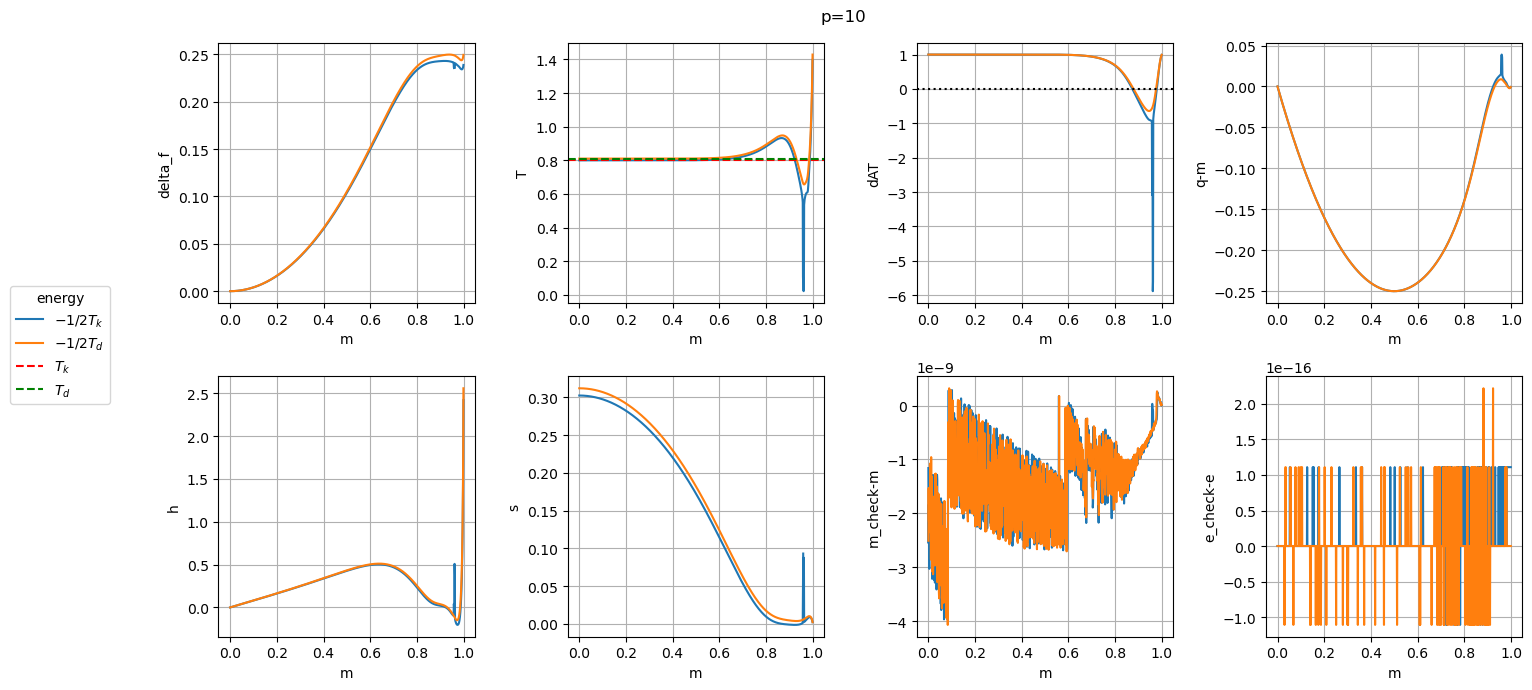

In [108]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle(f'p={p}')

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    for idx, (key, item) in enumerate(data.items()):
        if key == 'q':
            axs[idx // 4 , idx % 4].plot(ms, item[jdx,:]-ms, '-', label=legend_name)
            axs[idx // 4 , idx % 4].set_ylabel("q-m")
        elif key == 'm_check':
            axs[idx // 4 , idx % 4].plot(ms, item[jdx,:]-ms, '-', label=legend_name)
            axs[idx // 4 , idx % 4].set_ylabel("m_check-m")
        elif key == 'e_check':
            axs[idx // 4 , idx % 4].plot(ms, item[jdx,:]-e, '-', label=legend_name)
            axs[idx // 4 , idx % 4].set_ylabel("e_check-e")
        else:
            axs[idx // 4 , idx % 4].plot(ms, item[jdx,:], '-', label=legend_name)
            axs[idx // 4 , idx % 4].set_ylabel(key)

        axs[idx // 4 , idx % 4].set_xlabel('m')
        axs[idx // 4 , idx % 4].grid(True)

position_T = list(data.keys()).index('T')
axs[position_T // 4 , position_T % 4].axhline(y=T_kauz, color='r', linestyle='--', label=r'$T_k$')
axs[position_T // 4 , position_T % 4].axhline(y=T_dyn, color='g', linestyle='--', label=r'$T_d$')

position_dAT = list(data.keys()).index('dAT')
axs[position_dAT // 4 , position_dAT % 4].axhline(y=0, color='k', linestyle=':', label=r'$\Delta A = 0$')

handles, labels = [], []
# for ax in axs.flat:
ax = axs[0,1]
for handle, label in zip(*ax.get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)

lgd = fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
#plt.savefig(f'./imgs/FPpspin_p{p}.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=460)

ValueError: too many values to unpack (expected 2)

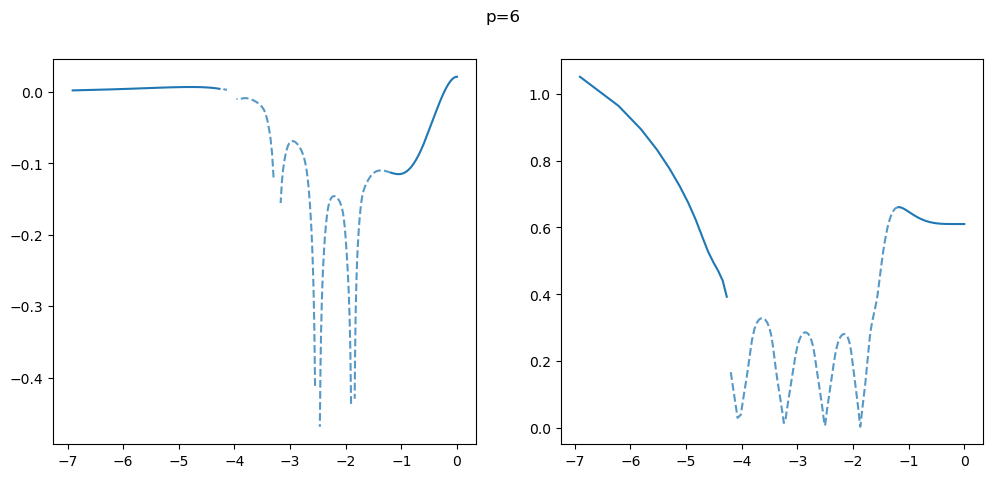

In [100]:
# plot s vs log(1-m) 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"p={p}")
data_filtered = {
    key: value for key, value in data.items() if key in ["q", "T", "s"]
}
for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    color = f"C{jdx:d}"
    stable_idxs = data["dAT"][jdx, :] > 0

    plot_dashed_instable(ax[0], np.log(1-ms), data["s"][jdx], stable_idxs, color, legend_name)
    plot_dashed_instable(ax[1], np.log(1-ms), data["T"][jdx], stable_idxs, color, legend_name)
    #ax[0].plot(np.log(1-ms), data["s"][jdx], label=legend_name)
    #ax[1].plot(np.log(1-ms), data["T"][jdx], label=legend_name)

ax[0].set_ylabel("s")
ax[0].set_xlabel("log(1-m)")
ax[0].grid(True)

ax[1].set_ylabel("T")
ax[1].set_xlabel("log(1-m)")
ax[1].grid(True)
handles, labels = [], []
for handle, label in zip(*ax[1].get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)
position_T = list(data_filtered.keys()).index("T")
ax[1].axhline(y=T_kauz, color="k", linestyle="-.", label=r"$T_k$")
ax[1].axhline(y=T_dyn, color="k", linestyle="--", label=r"$T_d$")

lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
#plt.savefig(f'./imgs/FPpspin_log1mm_p{p}.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=360)